In [12]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
import time
import pandas as pd
from qutip import *
from numpy import sin, cos, sqrt, array, linspace

### Base on Juan Restrepo's thesis
Title: "Theory of quantum optomechanics with unconventional nonlinear coupling schemes" pg. 101

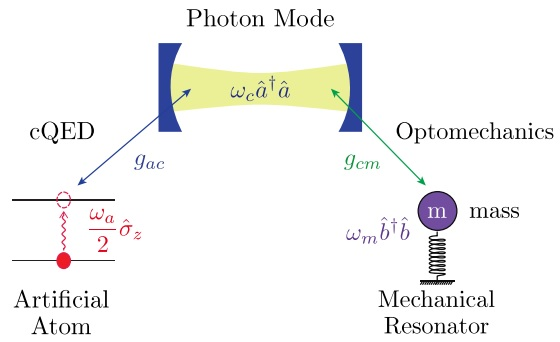

In [13]:
Image(filename='C:/Users/Ahmad/Desktop/2020/photo source/shem2.jpg',width=500, height=400)

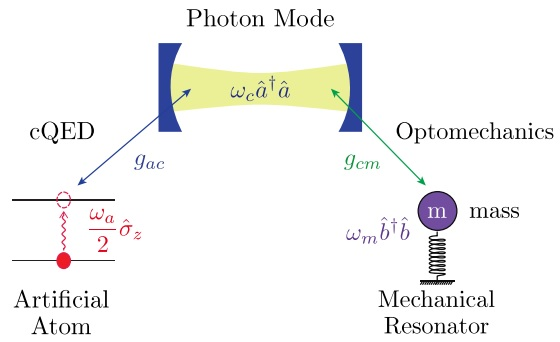

### Hamiltonian For this fully coupled syestem:

$\Large \hat{H}_{0}=\omega_{c}\hat{a}^\dagger \hat{a}+ \frac{\omega_{a}}{2}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
\Large \;\;\;\;\;\;\;\;\;\;\; +ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) $
 

### Coherent optical deriving and dissipation
Dynamics of the open system following Lindblad master equation

$\frac{d\hat{\rho}}{dt}= -i[\hat{H}_{0}+\hat{V}_{p}(t), \hat{\rho}] \\
  \;\;\;\;\;\;\; +\gamma_{c}L[\hat{a}]\hat{\rho}+\gamma_{a}L[\hat{\sigma}_{-}]\hat{\rho} \\
  \;\;\;\;\;\;\; +n_{th}\gamma_{m}L[\hat{b}^\dagger]
  +(n_{th}+1)\gamma_{m} L[\hat{b}]\hat{\rho}$

Which $\gamma_{m}$,$\gamma_{c}$ and $\gamma_{a}$ are the mechanical, cavity, and atomic
loss rates. $n_{th}$ is the thermal mean phonon occupancy. 

$\hat{V}_{p}(t)$ is coherent optical derive with frequency $\omega_{p}$ and amplitude $F_p$

$\hat{V}_{p}(t)= iF_p (\hat{a}^\dagger e^{-i\omega_p t}-\hat{a} e^{i\omega_p t})$

in order to remove t-dependence of H, we move to the rotating frame via unitary transformation...
Eventually, this is a H:

$ \hat{H}_{0}=\Delta_{cp}\hat{a}^\dagger \hat{a}+ \Delta_{ap}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
 \;\;\;\;\;\;\; +ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) \\
\;\;\;\;\;\;\; + iF_p (\hat{a}^\dagger -\hat{a} ) $


## Photon number
Time evolution of photon and phonon 

Expected to get result similar to following Figure 

Fig IV.14 pg(101)

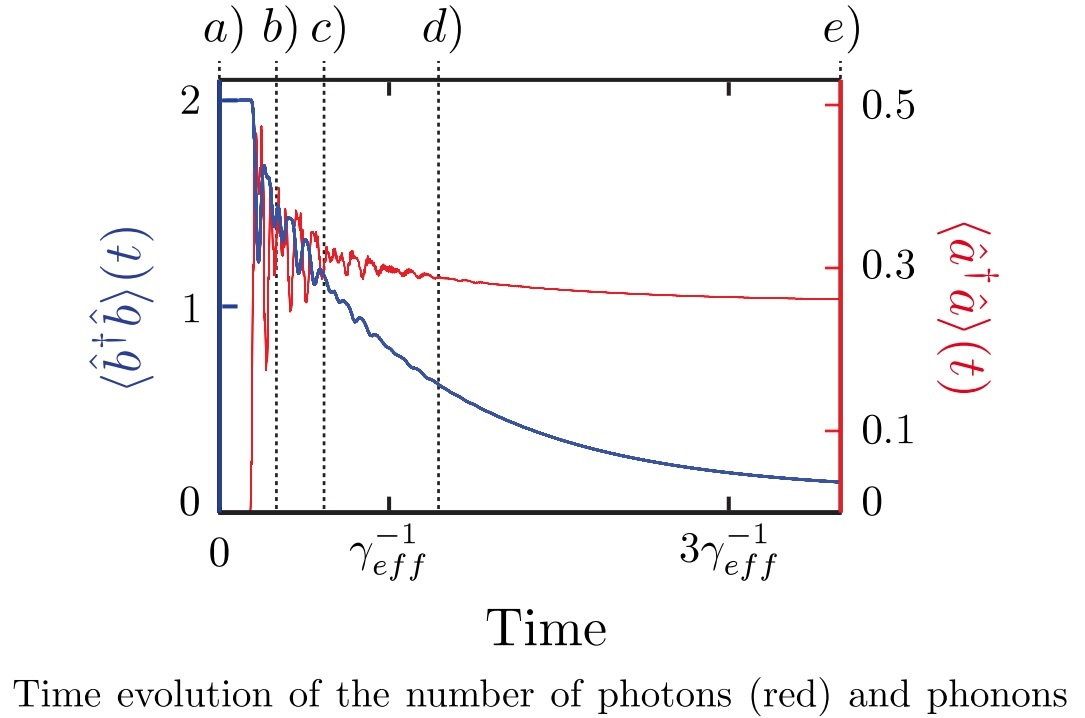

In [14]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/SinglePolaritonOptomechanics_corr_photNum_07.07.2020/thesis1.jpg'\
      ,width=550, height=450)

In [22]:
# parameter values
n_th=  2.15 # 3.45               # thermal mean phonon occupancy
wm = 1.0                   #  mechanical frequency
wc = 100 * wm                  # cavity frequency.... 
wa = wc                      # resonance case

gamma_m = wm * 1e-4            # mechanical loss
gamma_a = wc * 1e-4
gamma_c = gamma_a

g_ac = wm/2.0                # atom-cavity coupling strength
g_cm = wm/10.0               # cavity-resonator coupling
g_am = 0.0                  # atom-resonator coupling

F_p = gamma_c * 10.0 * sqrt(2)   # laser amplitude

delta_ac = wa - wc        # atom-cavity detuning 

omega_p = wc/2.0 + g_ac       # eigenenergies for atom-cavity subsystem
omega_m = wc/2.0 -  g_ac      # for case which n=1

wp = omega_m            # laser frequency


gamma_eff = 18 * gamma_m   # the number of phonons steadily decreases with an effective dissipation const


1/gamma_eff

555.5555555555555

In [23]:
Pars = {"$ \omega_c$": [wc],"$ \omega_a$": [wa],"$ \omega_m$": [wm],"$ g_{ac} /\omega_m$": [g_ac/wm],\
        "$\gamma_a/\omega_m$" : [gamma_a/wm],\
        "$g_{cm}/\omega_m$" : [g_cm/wm],"$Q_m$" : [wm/gamma_m],"$Q_c$":[wc/gamma_c],"$Q_a$" : [wa/gamma_a],\
        "$F_p/\gamma_a$" : [F_p/gamma_c],"$ \omega_{+}$": [omega_p],"$ \omega_{-}$": [omega_m],"$ \omega_p$": [wp]}
dataa = pd.DataFrame(Pars)
dataa

,$ \omega_c$,$ \omega_a$,$ \omega_m$,$ g_{ac} /\omega_m$,$\gamma_a/\omega_m$,$g_{cm}/\omega_m$,$Q_m$,$Q_c$,$Q_a$,$F_p/\gamma_a$,$ \omega_{+}$,$ \omega_{-}$,$ \omega_p$
0,100.0,100.0,1.0,0.5,0.01,0.1,10000.0,10000.0,10000.0,14.142136,50.5,49.5,49.5


### All the values that are used for this simulation base on above table

In [19]:
Nc = 7     # number of cavity fock states
Nm = 30    # number of mechanical fock states

a = tensor(qeye(Nm),destroy(Nc), qeye(2))     # cavity anihilation operator
b = tensor(destroy(Nm),qeye(Nc), qeye(2))      # phonon anihilation opr

sigma_m = tensor(qeye(Nm), qeye(Nc), destroy(2))
sigma_p = tensor(qeye(Nm), qeye(Nc), create(2))  # raising and lowering ops for atom
sigma_z = sigma_p * sigma_m - sigma_m * sigma_p


#sigma_m = tensor(qeye(Nm), qeye(Nc), sigmam())
#sigma_z = tensor(qeye(Nm), qeye(Nc), sigmaz())
#sigma_p = tensor(qeye(Nm), qeye(Nc), sigmap())  # raising and lowering ops for atom

    
collapse = []


rate = gamma_c
if rate > 0.0: 
    collapse.append(a * sqrt(rate))
rate = gamma_a
if rate > 0.0 : 
    collapse.append(sigma_m * sqrt(rate))
rate = n_th * gamma_m
if rate > 0.0: 
    collapse.append(b.dag() * sqrt(rate))
rate = (n_th+1) * gamma_m
if rate > 0.0 : 
    collapse.append(b * sqrt(rate))

expct_ops = []
expct_ops.append(a.dag()*a)
expct_ops.append(b.dag()*b)
 
# Hamiltonian of the system (atom+cavity+oscilator) with a laser derive
    
H = (wc-wp) * a.dag() * a + 0.5 * (wa-wp) *sigma_z + wm * b.dag() * b \
+ 1j * g_ac * (sigma_p * a - sigma_m * a.dag()) - g_cm * a.dag() * a *(b.dag() + b) \
+ 1j* F_p *(a.dag()-a)

In [20]:
psi0 = tensor(basis(Nm,2),basis(Nc,0),basis(2,0));    # Initial state, the mechanical resonator 
                                                      # in a Fock state with 2 phonons

times = np.linspace(0.0, 20,700)   # 3/gamma_eff
opt=Options(nsteps=5000)
#rhob=psi0.ptrace(0)
output = mesolve(H, psi0, times,collapse,expct_ops,options=opt)   # master eq solver, in order to find expct values

#rho = output.states

#expect_bb = expect(b.dag()* b, rhob)
#expect_aa = expect(a.dag()*a,rho)
#[expct_ops]

Text(0, 0.5, '$\\langle a^\\dagger a \\rangle$')

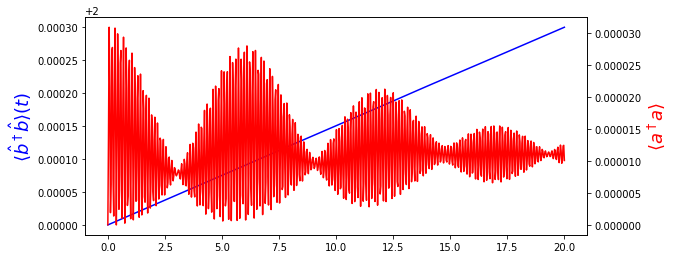

In [21]:
## plot expectations values as a function of time
fig, ax1= plt.subplots(figsize=(9,4))

ax2 = ax1.twinx()    # instantiate a second axes that shares the same x-axis
ax1.plot(times,output.expect[1],'b')    
ax2.plot(times ,output.expect[0],'r')

#ax1.set_xscale('log')
#ax2.set_yscale('log')

ax1.set_ylabel(r'$\langle \hat{b}^\dagger \hat{b} \rangle(t)$',fontsize=18,color='blue')
ax2.set_ylabel(r'$\langle a^\dagger a \rangle$',fontsize=18,color='red')
#ax1.set_ylim([0,2])
#ax1.set_ylim([1.3,2.25])
#fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [ ]:


result = mesolve(H1, psi0, times,collapse,[])

rhotO=result.ptrace(0)

bdagb.append(expect(b.dag()* b, rho_ss))

steady state
$\langle b^\dagger b \rangle$
